<h1 style="text-align: center">
Deep Learning HW3 </br>
VAE and CVAE
</h1>


### Full Name: Mohammad Taslimi
### Student ID: 99101321

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
import copy

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 143126142.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93685764.75it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 78228755.93it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19782480.55it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

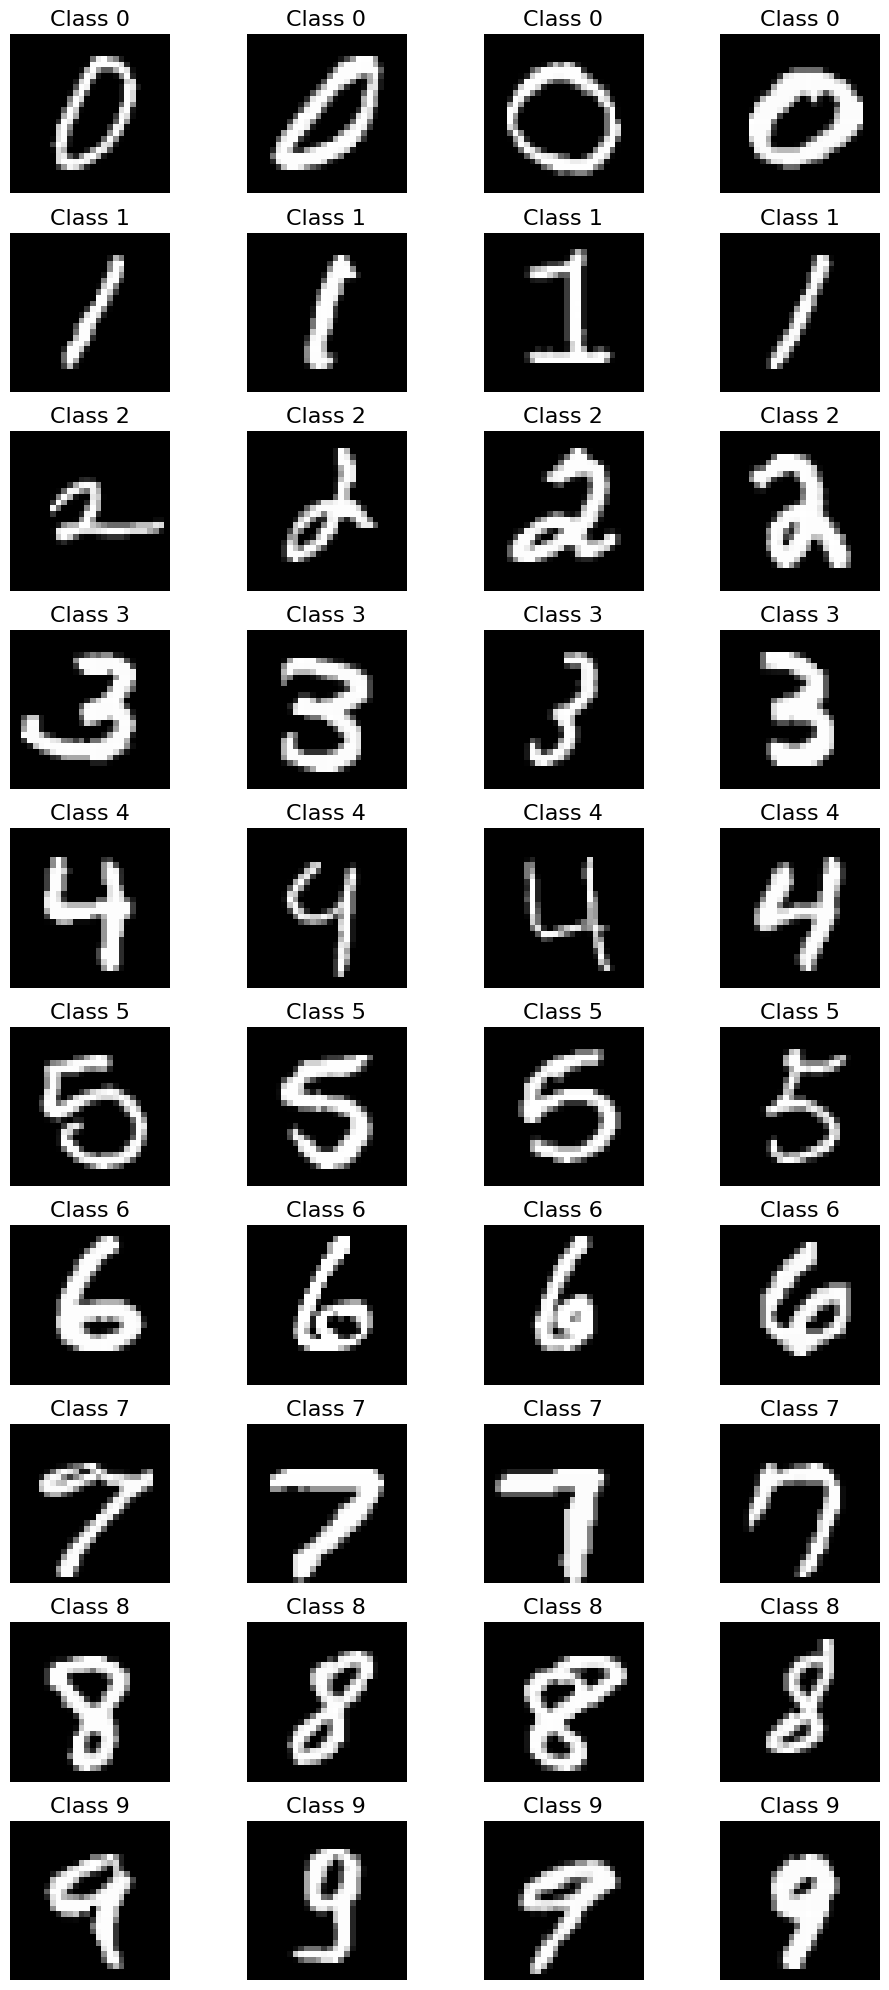

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # TODO: Implement the forward pass
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [9]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence

In [14]:
# Training Loop - VAE (MLP)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_vae_mlp(model, train_loader, num_epochs=50, learning_rate=1e-3):
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            data = data.view(data.size(0), -1).to(device)
            recon, mu, logvar = model(data)
            recon = recon.view(recon.size(0), -1)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2).to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = copy.deepcopy(model)  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model.state_dict(), 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/50], Loss: 171.57652029622395
Sample Images:


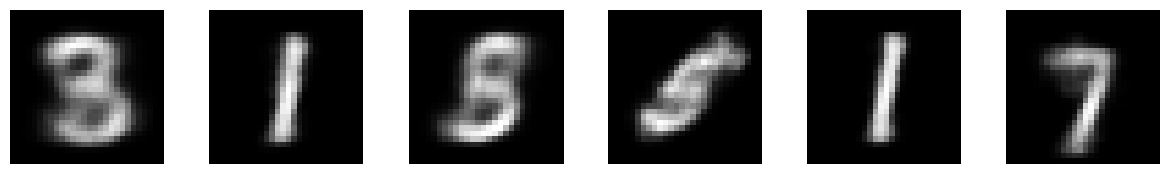


##################################################
VAE-MLP Epoch [2/50], Loss: 154.4039275797526
Sample Images:


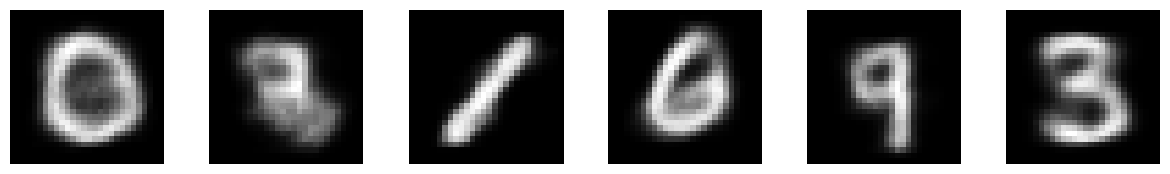


##################################################
VAE-MLP Epoch [3/50], Loss: 149.84054412434895
Sample Images:


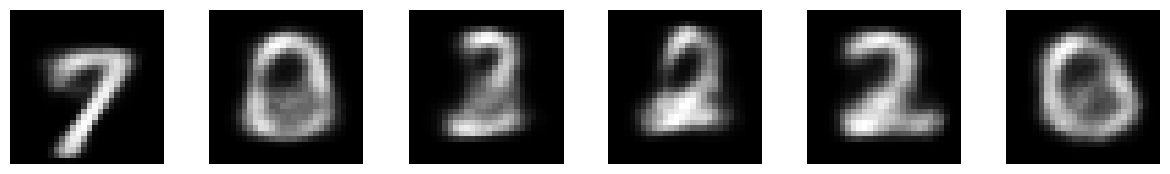


##################################################
VAE-MLP Epoch [4/50], Loss: 147.1877087483724
Sample Images:


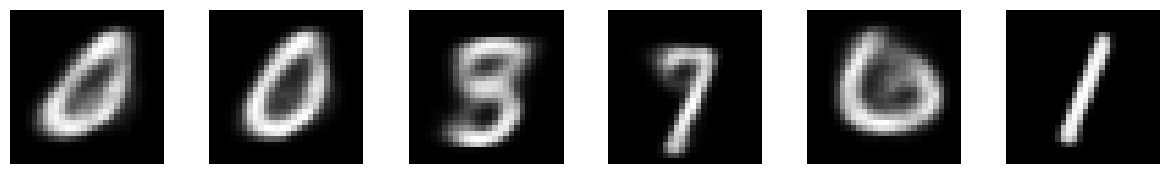


##################################################
VAE-MLP Epoch [5/50], Loss: 145.34465930175782
Sample Images:


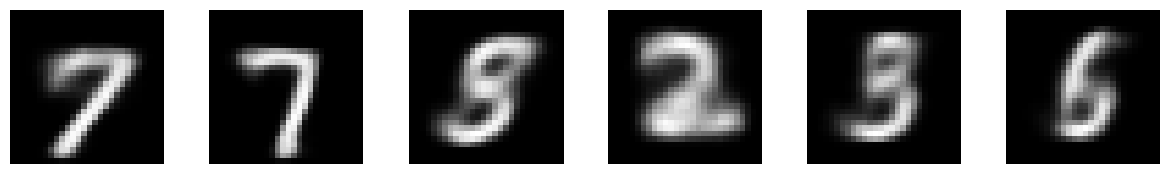


##################################################
VAE-MLP Epoch [6/50], Loss: 144.14805223795574
Sample Images:


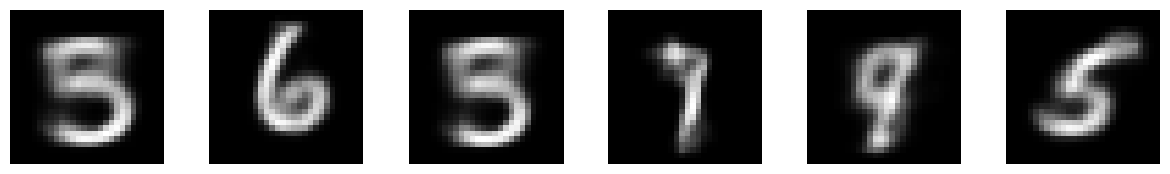


##################################################
VAE-MLP Epoch [7/50], Loss: 143.29236468098958
Sample Images:


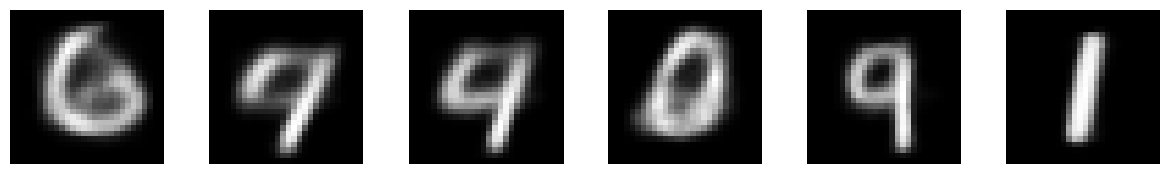


##################################################
VAE-MLP Epoch [8/50], Loss: 142.38737533365887
Sample Images:


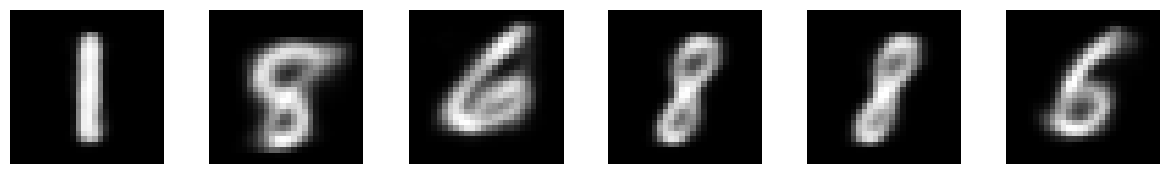


##################################################
VAE-MLP Epoch [9/50], Loss: 141.82924349772136
Sample Images:


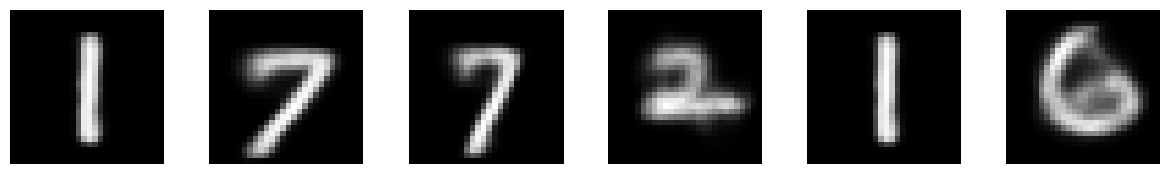


##################################################
VAE-MLP Epoch [10/50], Loss: 141.34401394856772
Sample Images:


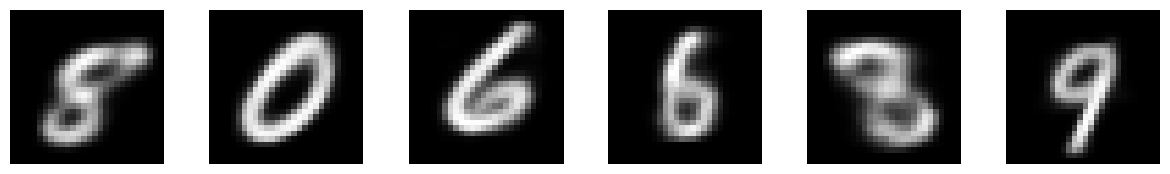


##################################################
VAE-MLP Epoch [11/50], Loss: 140.63205810546876
Sample Images:


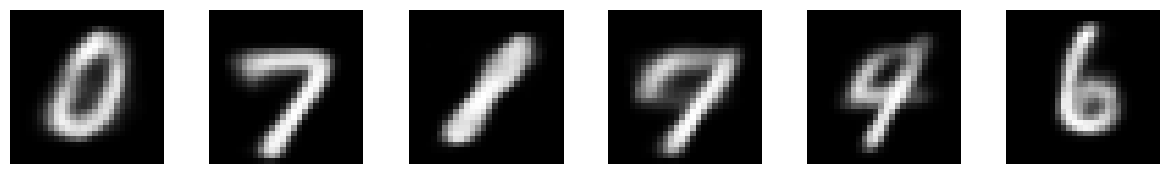


##################################################
VAE-MLP Epoch [12/50], Loss: 140.06527622884116
Sample Images:


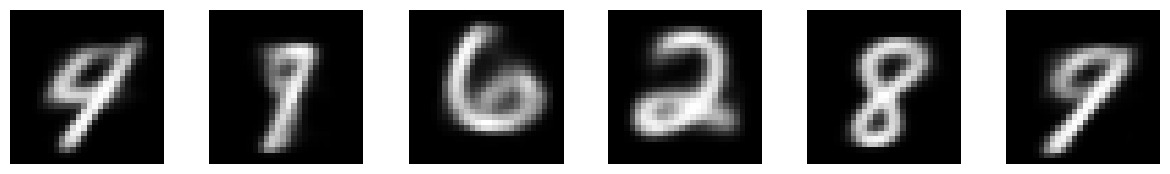


##################################################
VAE-MLP Epoch [13/50], Loss: 139.96801024576823
Sample Images:


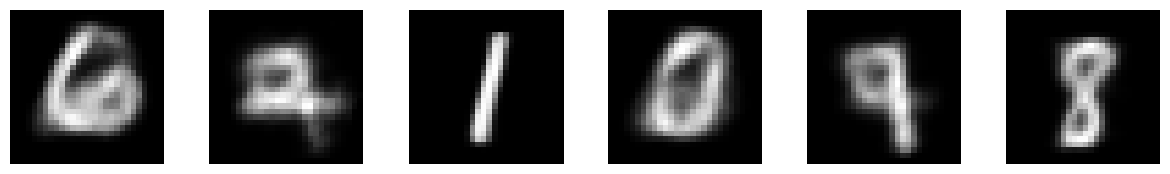


##################################################
VAE-MLP Epoch [14/50], Loss: 139.49794522298177
Sample Images:


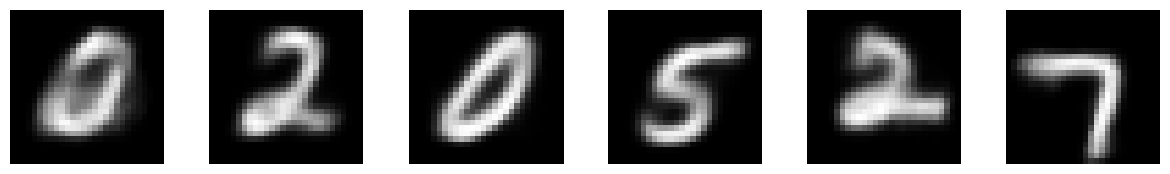


##################################################
VAE-MLP Epoch [15/50], Loss: 139.45980287272135
Sample Images:


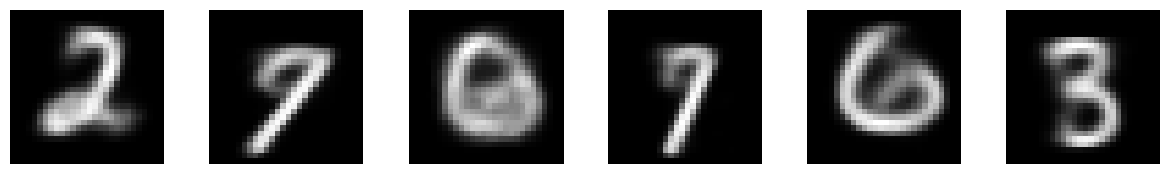


##################################################
VAE-MLP Epoch [16/50], Loss: 138.94468500976564
Sample Images:


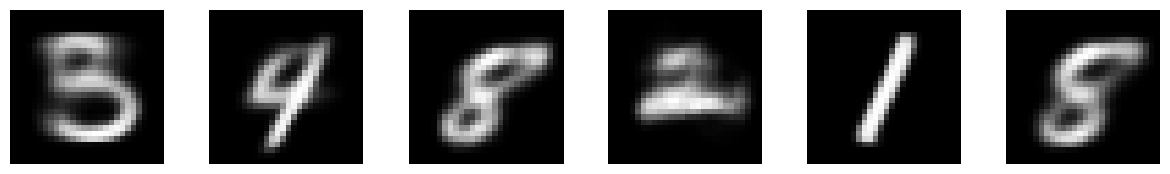


##################################################
VAE-MLP Epoch [17/50], Loss: 138.73553147786458
Sample Images:


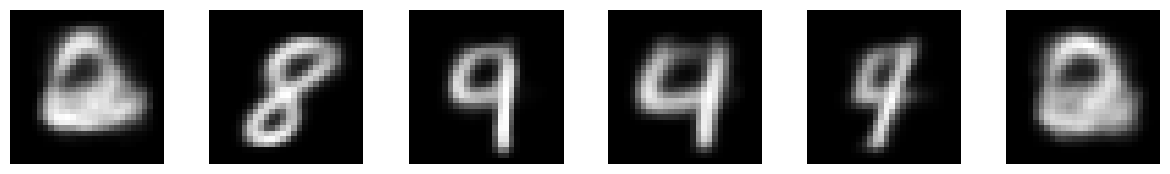


##################################################
VAE-MLP Epoch [18/50], Loss: 138.6788149983724
Sample Images:


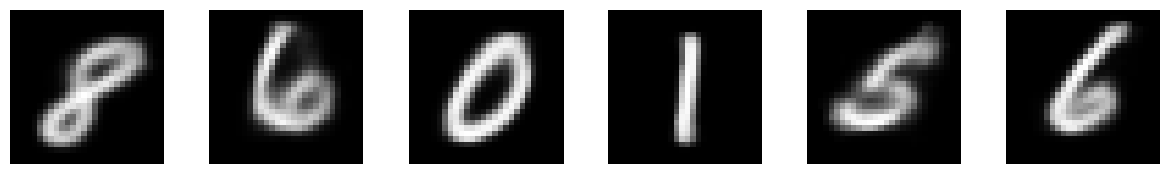


##################################################
VAE-MLP Epoch [19/50], Loss: 138.8514868001302
Sample Images:


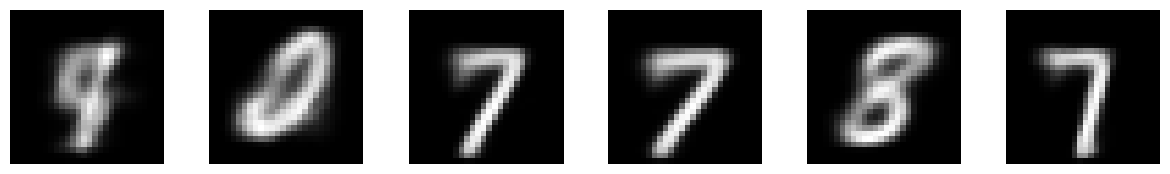


##################################################
VAE-MLP Epoch [20/50], Loss: 138.2394895345052
Sample Images:


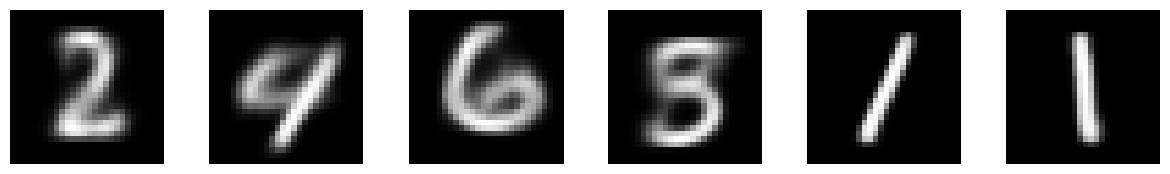


##################################################
VAE-MLP Epoch [21/50], Loss: 137.87932622070312
Sample Images:


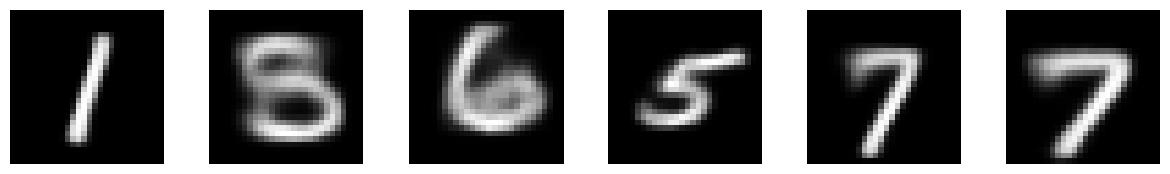


##################################################
VAE-MLP Epoch [22/50], Loss: 137.75695513509115
Sample Images:


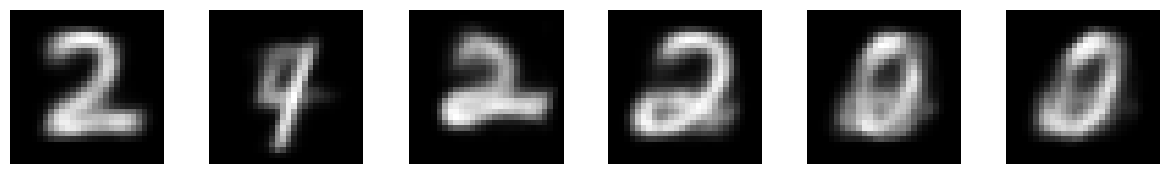


##################################################
VAE-MLP Epoch [23/50], Loss: 137.54436756184896
Sample Images:


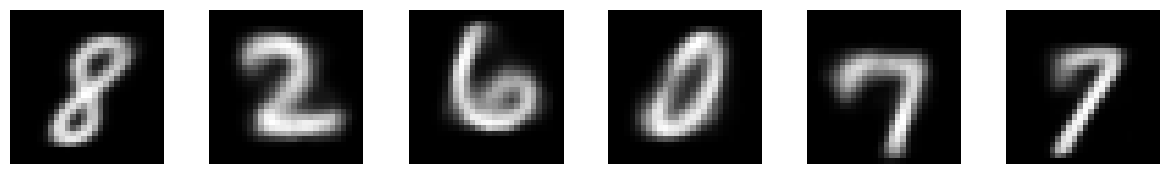


##################################################
VAE-MLP Epoch [24/50], Loss: 137.44124461263021
Sample Images:


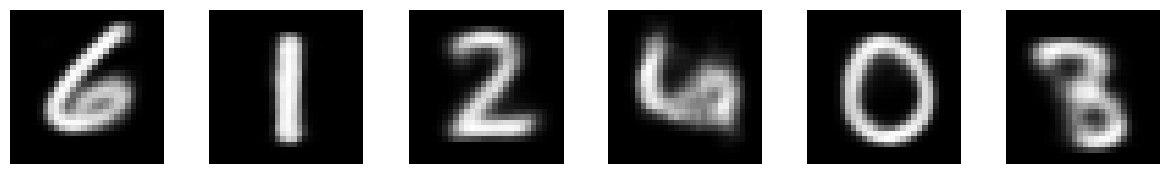


##################################################
VAE-MLP Epoch [25/50], Loss: 137.25493104248048
Sample Images:


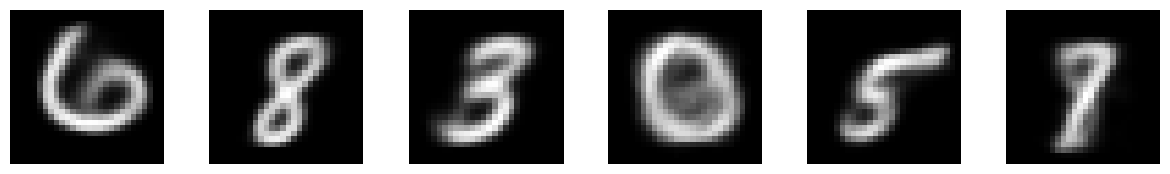


##################################################
VAE-MLP Epoch [26/50], Loss: 137.10770375976563
Sample Images:


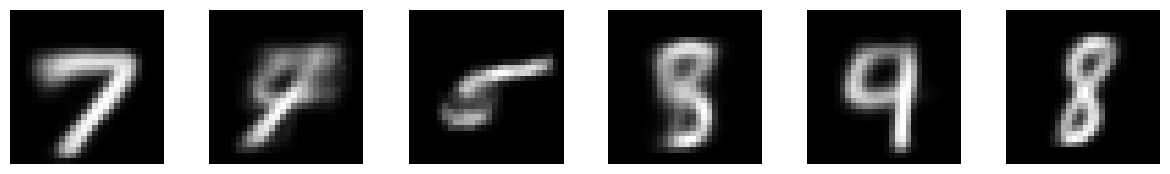


##################################################
VAE-MLP Epoch [27/50], Loss: 136.9902616007487
Sample Images:


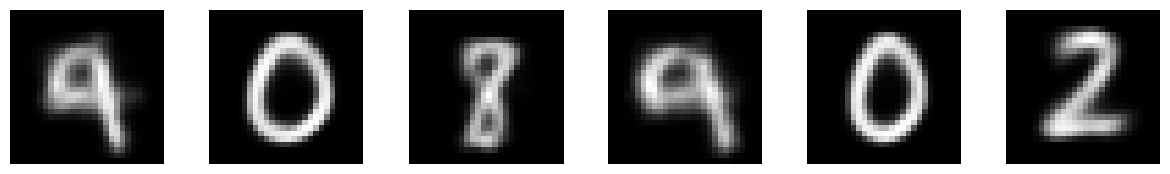


##################################################
VAE-MLP Epoch [28/50], Loss: 136.7930348795573
Sample Images:


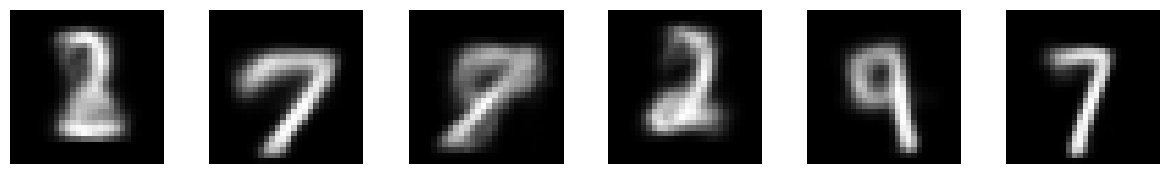


##################################################
VAE-MLP Epoch [29/50], Loss: 136.64091845703126
Sample Images:


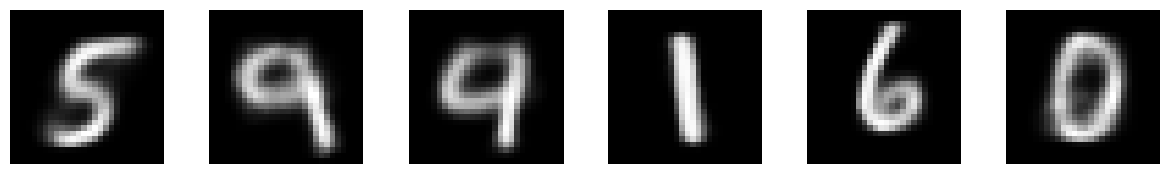


##################################################
VAE-MLP Epoch [30/50], Loss: 136.44758091634114
Sample Images:


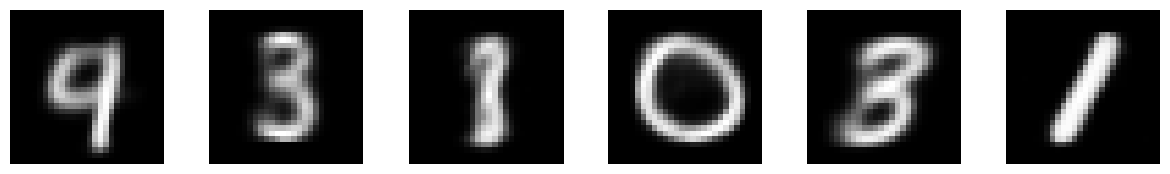


##################################################
VAE-MLP Epoch [31/50], Loss: 136.23508122151694
Sample Images:


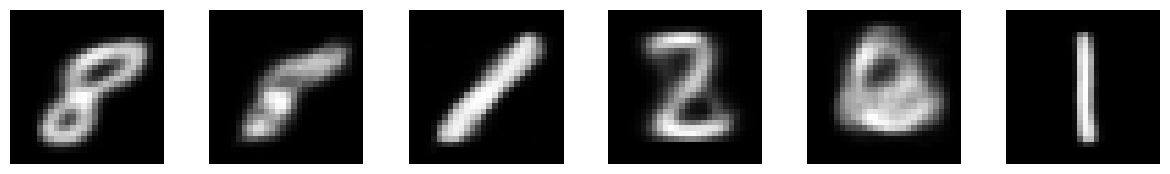


##################################################
VAE-MLP Epoch [32/50], Loss: 136.09157017415365
Sample Images:


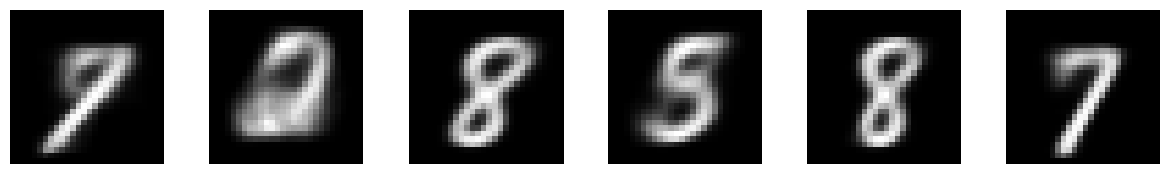


##################################################
VAE-MLP Epoch [33/50], Loss: 135.95894586588543
Sample Images:


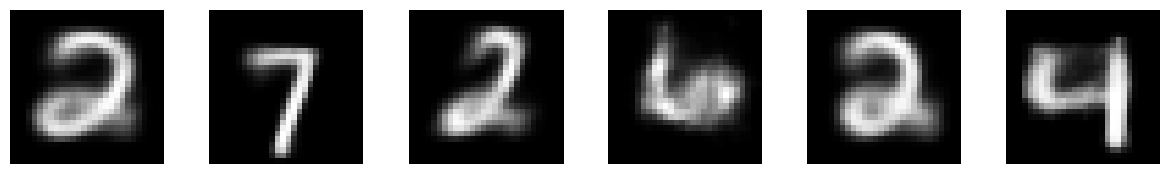


##################################################
VAE-MLP Epoch [34/50], Loss: 136.17787724609374
Sample Images:


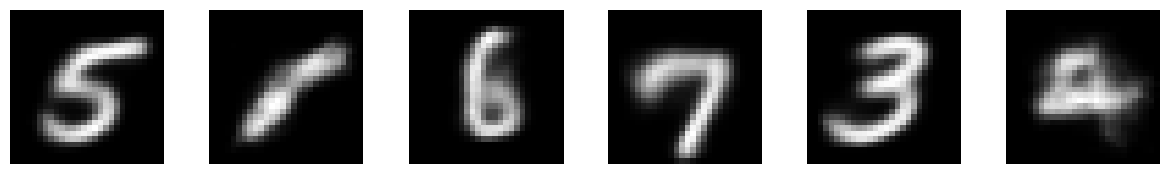


##################################################
VAE-MLP Epoch [35/50], Loss: 135.96794860432942
Sample Images:


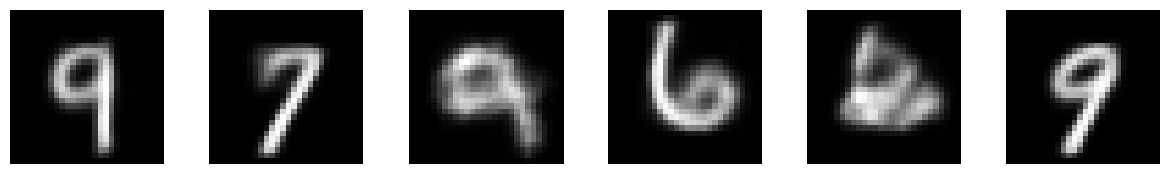


##################################################
VAE-MLP Epoch [36/50], Loss: 136.04204750976564
Sample Images:


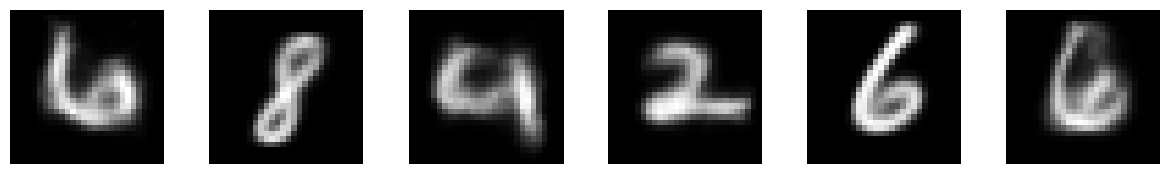


##################################################
VAE-MLP Epoch [37/50], Loss: 135.83747503255208
Sample Images:


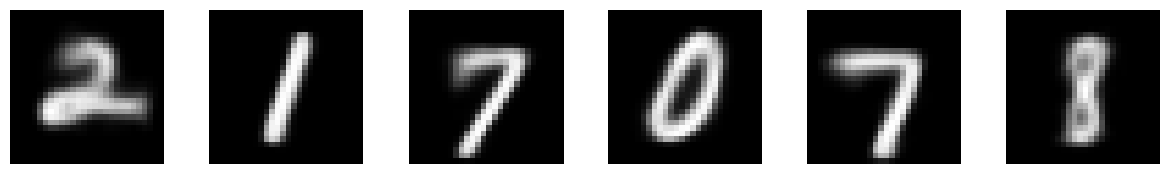


##################################################
VAE-MLP Epoch [38/50], Loss: 135.7756766031901
Sample Images:


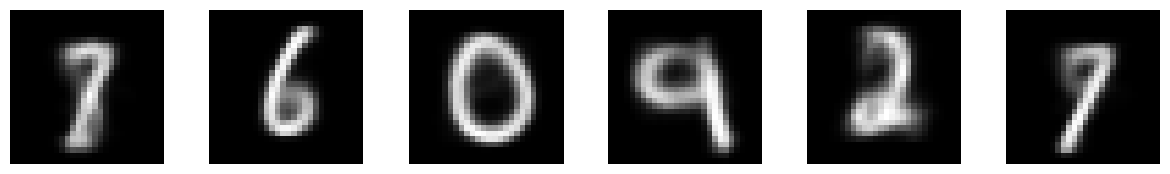


##################################################
VAE-MLP Epoch [39/50], Loss: 135.64000734863282
Sample Images:


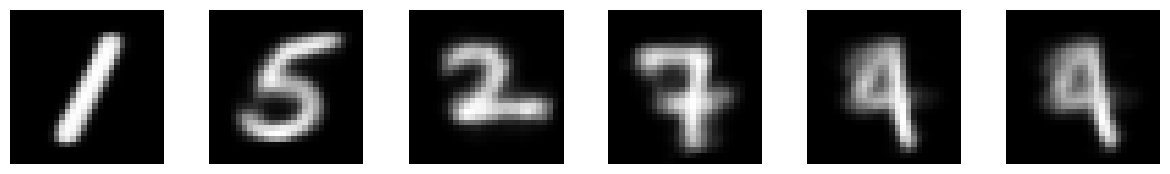


##################################################
VAE-MLP Epoch [40/50], Loss: 135.73872600504558
Sample Images:


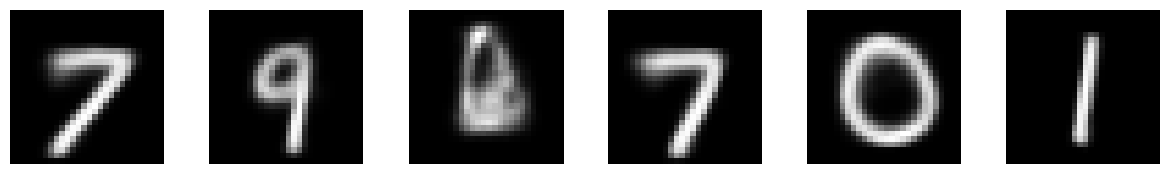


##################################################
VAE-MLP Epoch [41/50], Loss: 135.3896601155599
Sample Images:


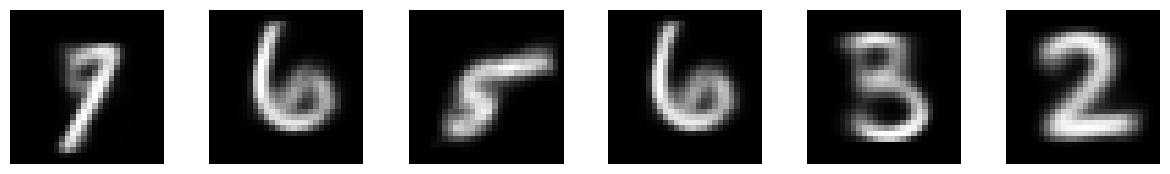


##################################################
VAE-MLP Epoch [42/50], Loss: 135.09689481608072
Sample Images:


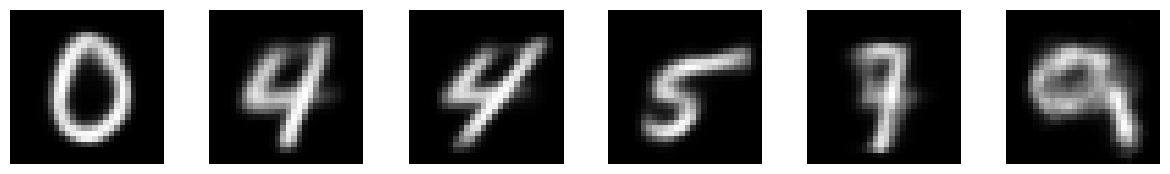


##################################################
VAE-MLP Epoch [43/50], Loss: 135.15358786214193
Sample Images:


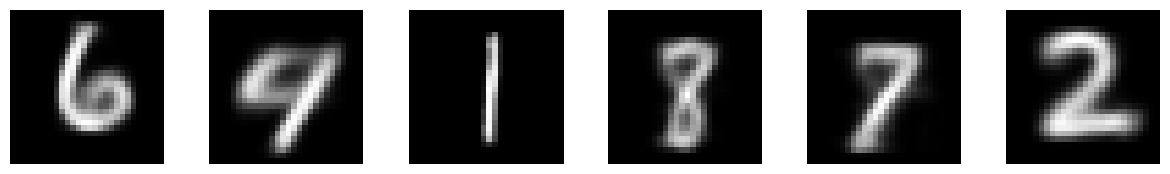


##################################################
VAE-MLP Epoch [44/50], Loss: 135.08330633138021
Sample Images:


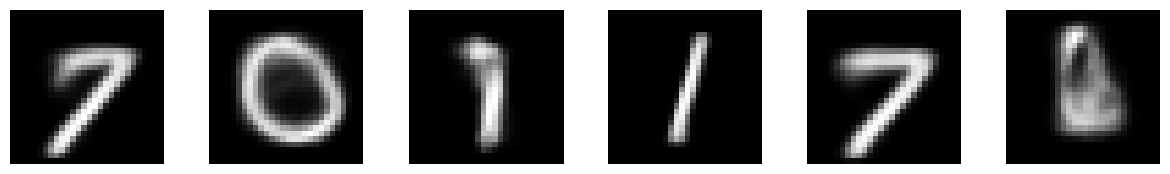


##################################################
VAE-MLP Epoch [45/50], Loss: 135.1894869140625
Sample Images:


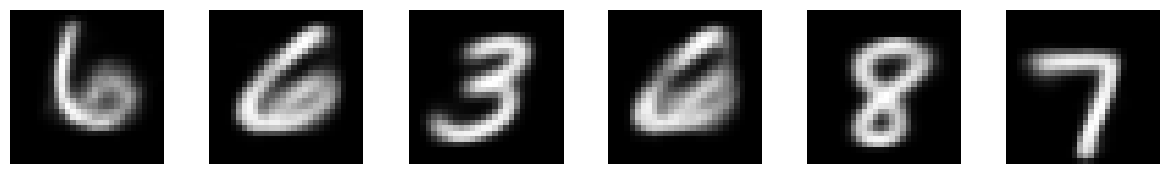


##################################################
VAE-MLP Epoch [46/50], Loss: 134.90866027832033
Sample Images:


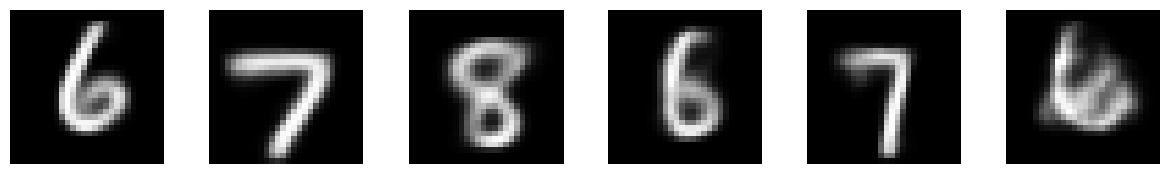


##################################################
VAE-MLP Epoch [47/50], Loss: 134.869817578125
Sample Images:


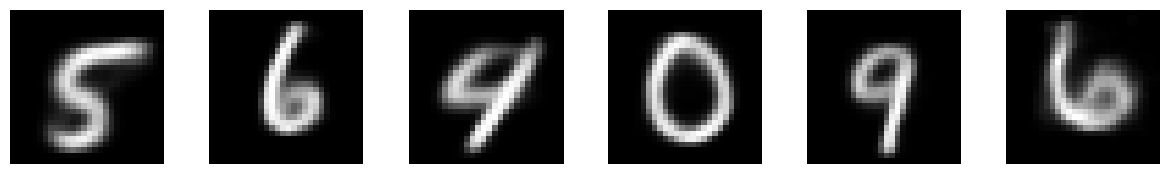


##################################################
VAE-MLP Epoch [48/50], Loss: 134.80618505045572
Sample Images:


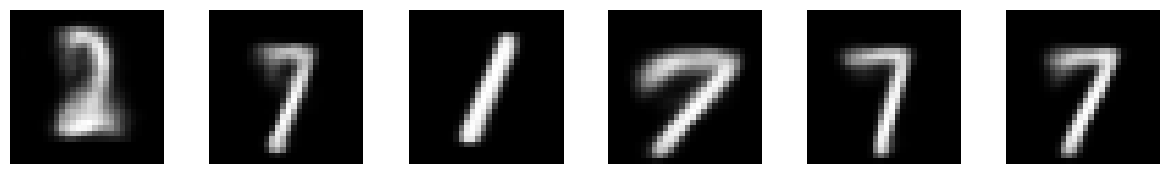


##################################################
VAE-MLP Epoch [49/50], Loss: 134.7460985595703
Sample Images:


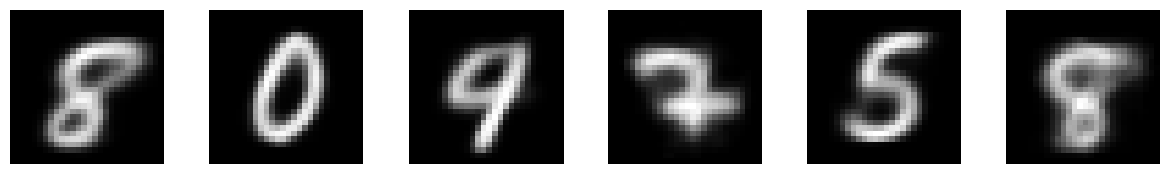


##################################################
VAE-MLP Epoch [50/50], Loss: 134.53270037434896
Sample Images:


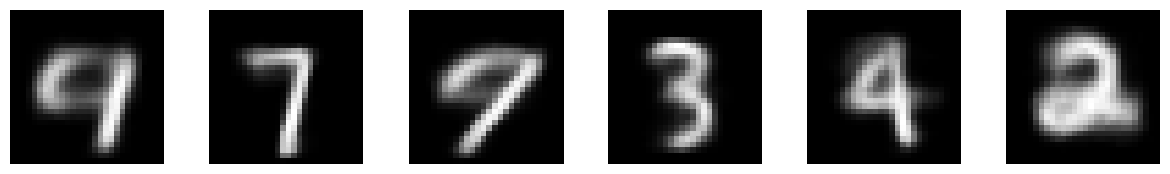

Best model saved as 'best_vae_mlp_model.pth'


In [15]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=500, latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [16]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # To get the output in the range [0, 1]
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat((x, y), dim=1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        z = torch.cat((z, y), dim=1)
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar, class_logits


In [17]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(data.size(0), -1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels)

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence + ce_loss


In [18]:
# Training Loop - CVAE (MLP)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_cvae_mlp(model, train_loader, num_epochs=64, learning_rate=1e-2):
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.85)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            data = data.view(data.size(0), -1).to(device)
            recon, mu, logvar, class_logits = model(data, labels_one_hot)

            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels.to(device))

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        scheduler.step()
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2).to(device)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1).to(device)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = copy.deepcopy(model)

    # TODO: Save the best model to a file
    torch.save(best_model.state_dict(), 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/64], Loss: 149.86422602539062
Sample Images:


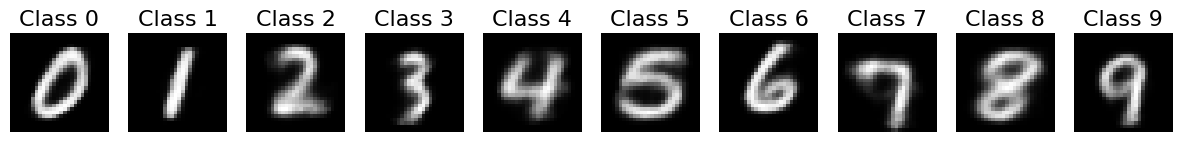


##################################################
CVAE-MLP Epoch [2/64], Loss: 139.60455397135416
Sample Images:


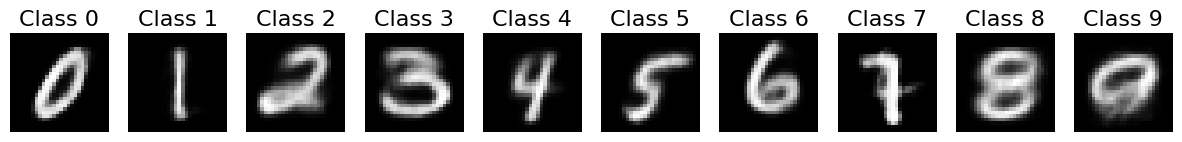


##################################################
CVAE-MLP Epoch [3/64], Loss: 138.0800608561198
Sample Images:


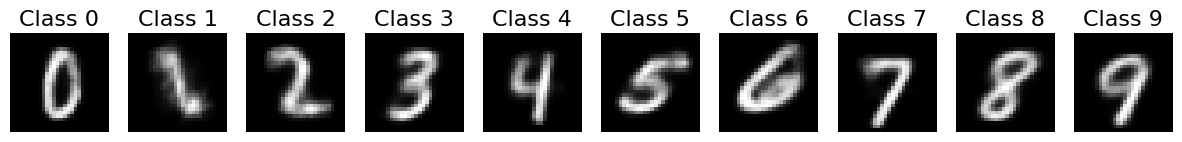


##################################################
CVAE-MLP Epoch [4/64], Loss: 137.08428627929686
Sample Images:


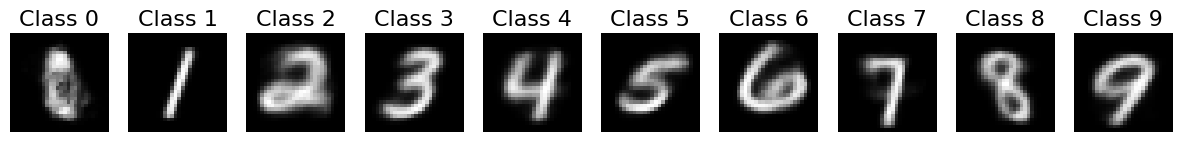


##################################################
CVAE-MLP Epoch [5/64], Loss: 136.68431822102863
Sample Images:


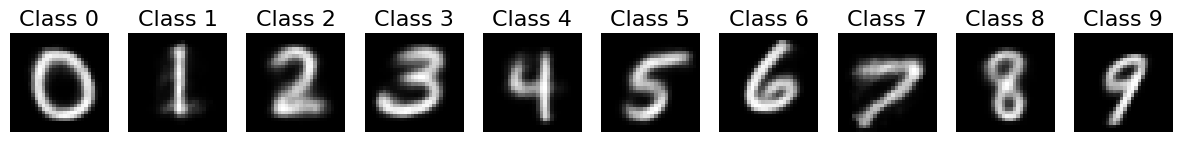


##################################################
CVAE-MLP Epoch [6/64], Loss: 136.41369592285156
Sample Images:


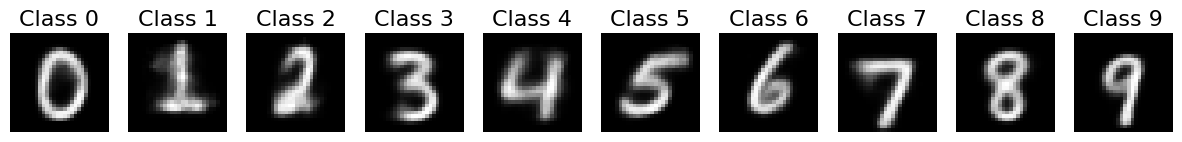


##################################################
CVAE-MLP Epoch [7/64], Loss: 136.1718583577474
Sample Images:


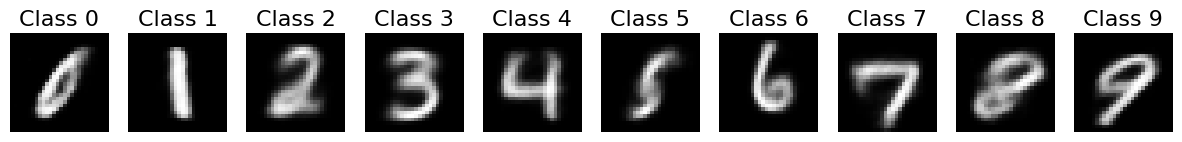


##################################################
CVAE-MLP Epoch [8/64], Loss: 136.04044517415363
Sample Images:


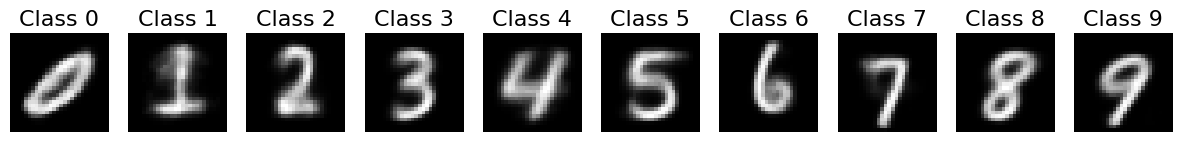


##################################################
CVAE-MLP Epoch [9/64], Loss: 135.25995270996094
Sample Images:


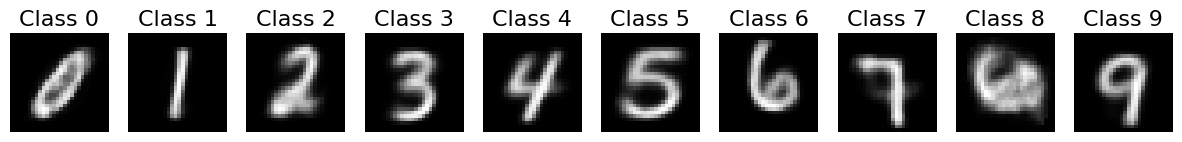


##################################################
CVAE-MLP Epoch [10/64], Loss: 135.2614008626302
Sample Images:


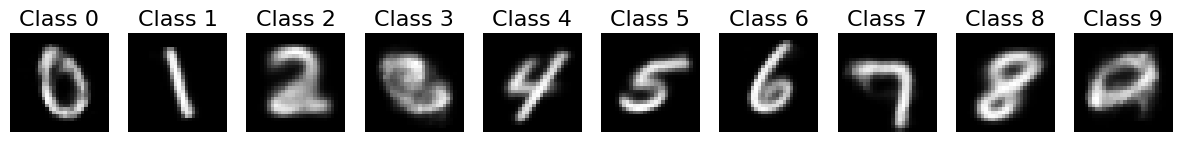


##################################################
CVAE-MLP Epoch [11/64], Loss: 135.07491559244792
Sample Images:


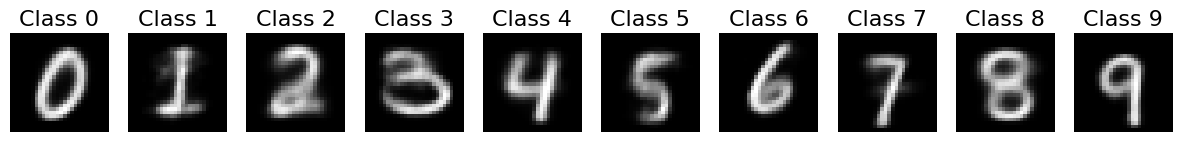


##################################################
CVAE-MLP Epoch [12/64], Loss: 134.98247972005208
Sample Images:


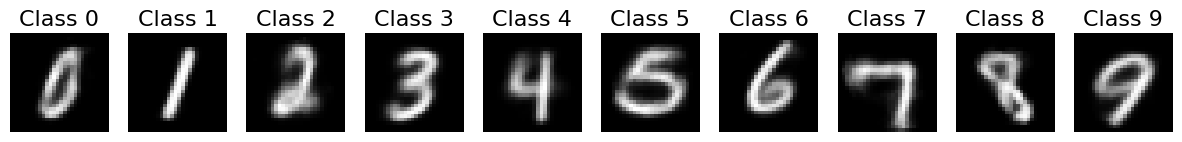


##################################################
CVAE-MLP Epoch [13/64], Loss: 134.8540013997396
Sample Images:


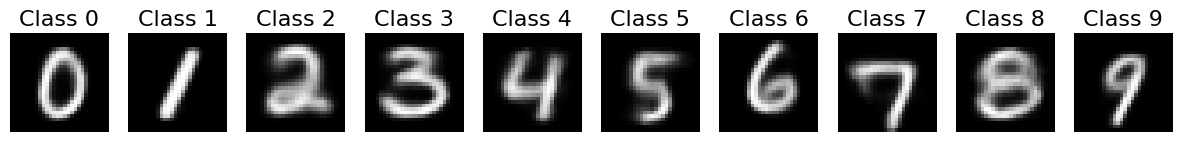


##################################################
CVAE-MLP Epoch [14/64], Loss: 134.79016813151043
Sample Images:


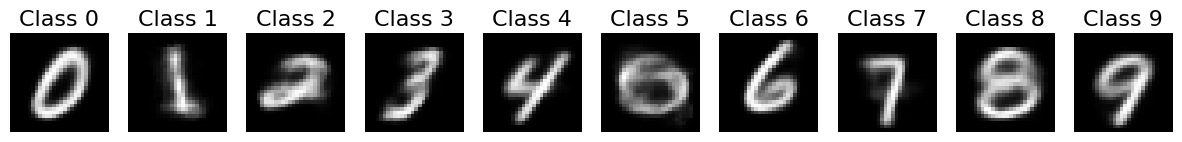


##################################################
CVAE-MLP Epoch [15/64], Loss: 134.7318622233073
Sample Images:


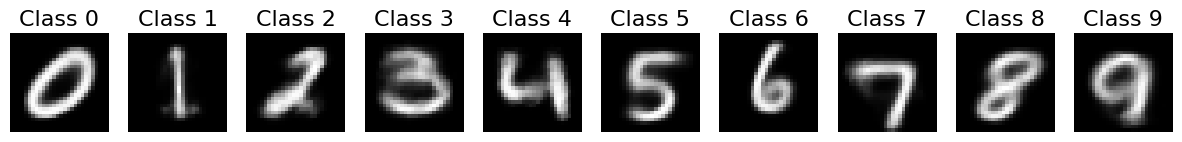


##################################################
CVAE-MLP Epoch [16/64], Loss: 134.7116322591146
Sample Images:


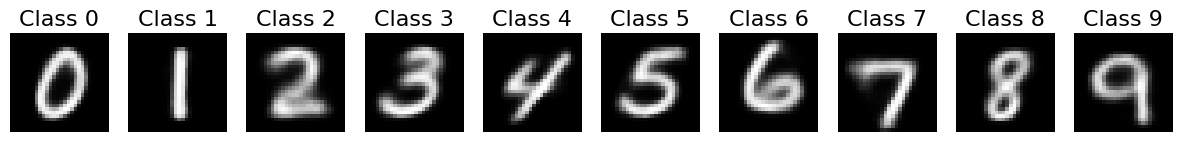


##################################################
CVAE-MLP Epoch [17/64], Loss: 134.19964383951822
Sample Images:


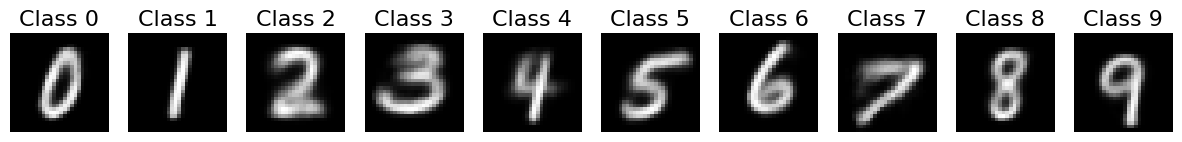


##################################################
CVAE-MLP Epoch [18/64], Loss: 134.12894442952475
Sample Images:


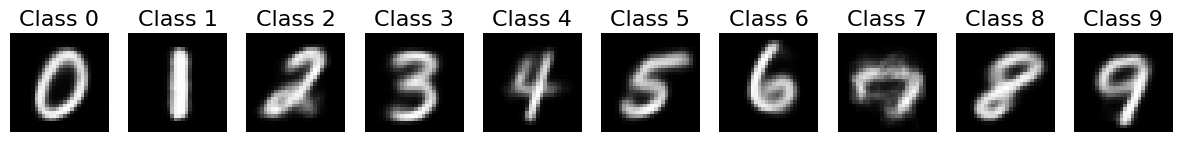


##################################################
CVAE-MLP Epoch [19/64], Loss: 134.05628996988932
Sample Images:


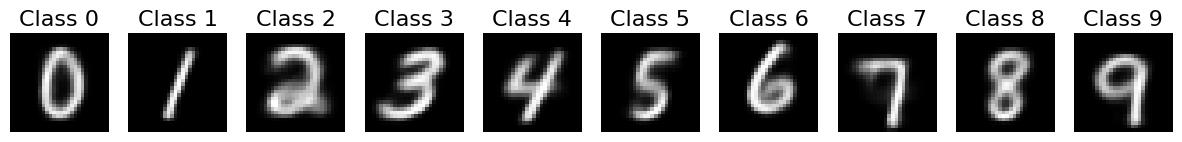


##################################################
CVAE-MLP Epoch [20/64], Loss: 134.0828277750651
Sample Images:


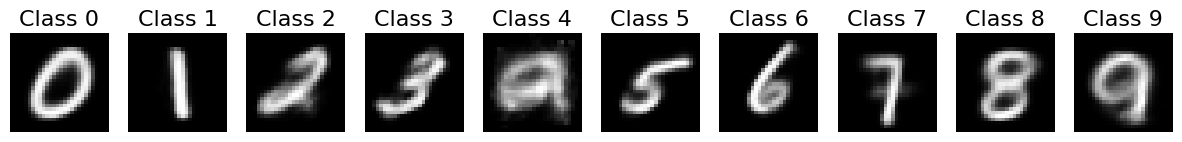


##################################################
CVAE-MLP Epoch [21/64], Loss: 133.97963341878256
Sample Images:


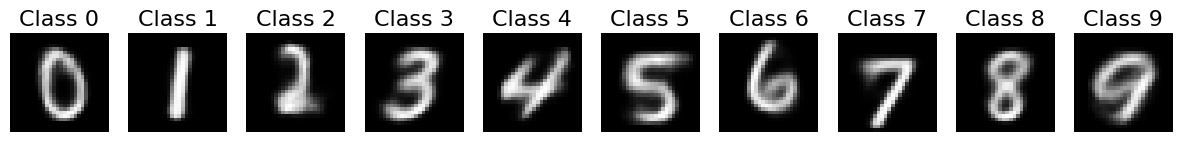


##################################################
CVAE-MLP Epoch [22/64], Loss: 133.87216521809896
Sample Images:


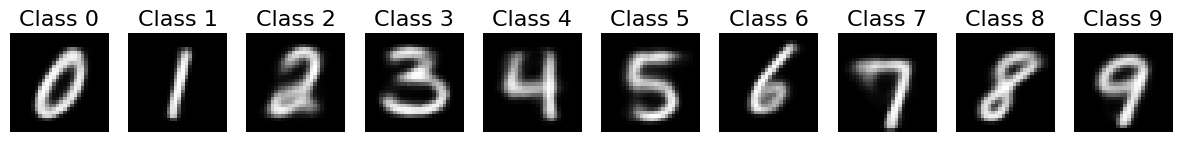


##################################################
CVAE-MLP Epoch [23/64], Loss: 133.92338553873697
Sample Images:


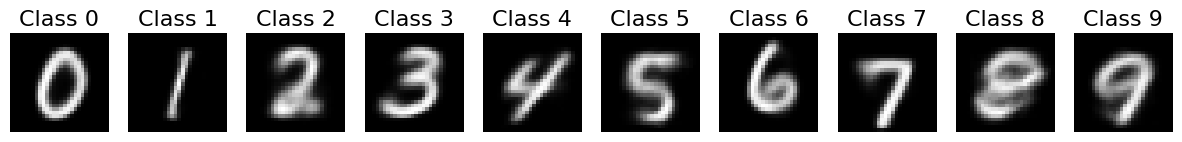


##################################################
CVAE-MLP Epoch [24/64], Loss: 133.86579743652345
Sample Images:


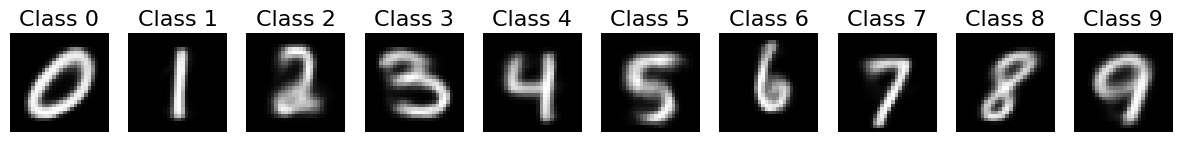


##################################################
CVAE-MLP Epoch [25/64], Loss: 133.46520598958332
Sample Images:


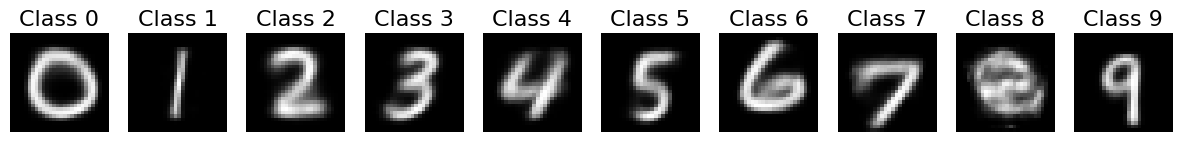


##################################################
CVAE-MLP Epoch [26/64], Loss: 133.45942798665365
Sample Images:


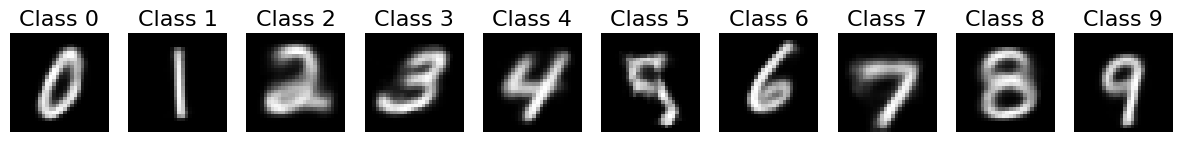


##################################################
CVAE-MLP Epoch [27/64], Loss: 133.40213955078124
Sample Images:


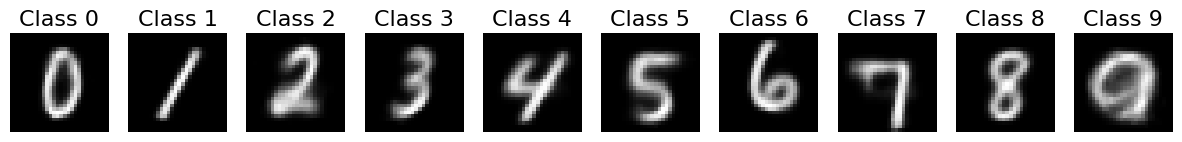


##################################################
CVAE-MLP Epoch [28/64], Loss: 133.31247266438803
Sample Images:


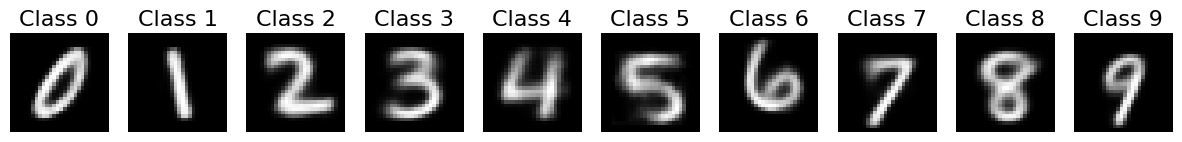


##################################################
CVAE-MLP Epoch [29/64], Loss: 133.37474281412761
Sample Images:


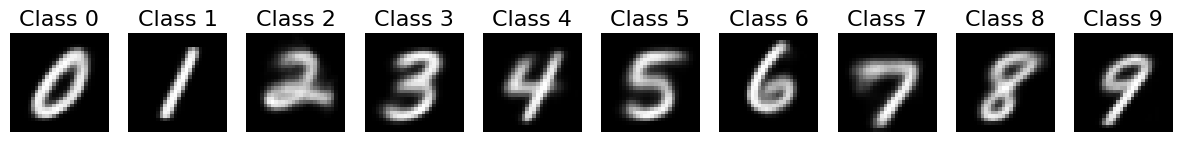


##################################################
CVAE-MLP Epoch [30/64], Loss: 133.33758163248697
Sample Images:


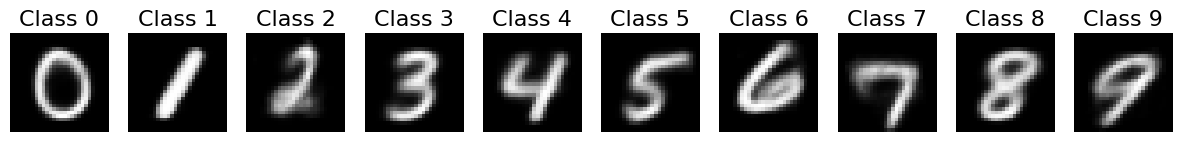


##################################################
CVAE-MLP Epoch [31/64], Loss: 133.31417591959635
Sample Images:


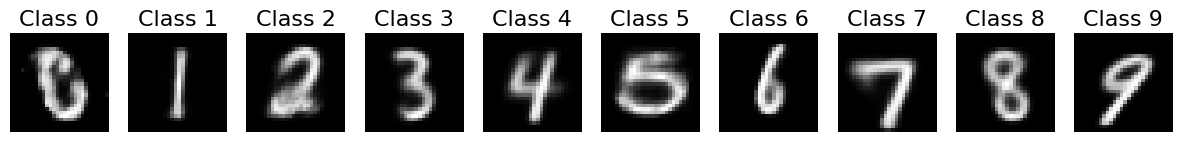


##################################################
CVAE-MLP Epoch [32/64], Loss: 133.27517334798176
Sample Images:


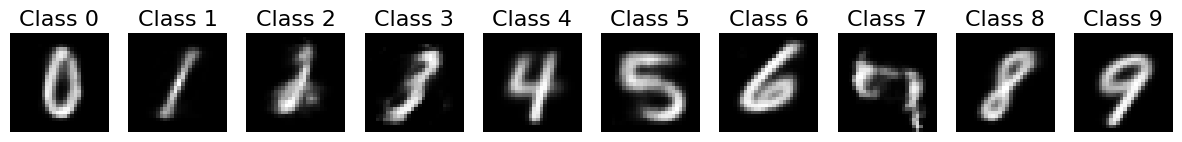


##################################################
CVAE-MLP Epoch [33/64], Loss: 132.8843118326823
Sample Images:


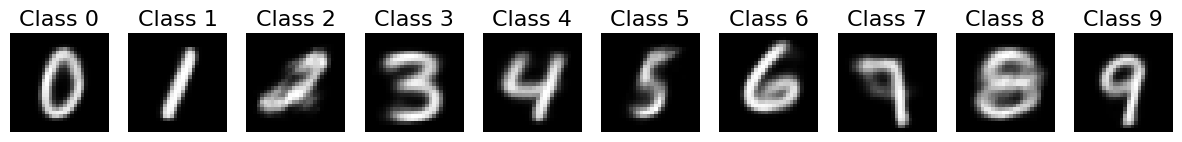


##################################################
CVAE-MLP Epoch [34/64], Loss: 132.96054178059896
Sample Images:


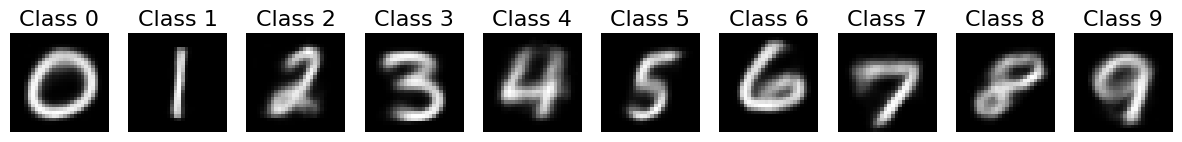


##################################################
CVAE-MLP Epoch [35/64], Loss: 132.91642797851563
Sample Images:


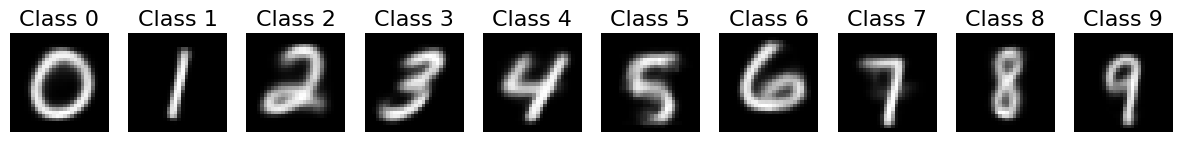


##################################################
CVAE-MLP Epoch [36/64], Loss: 132.84197493489583
Sample Images:


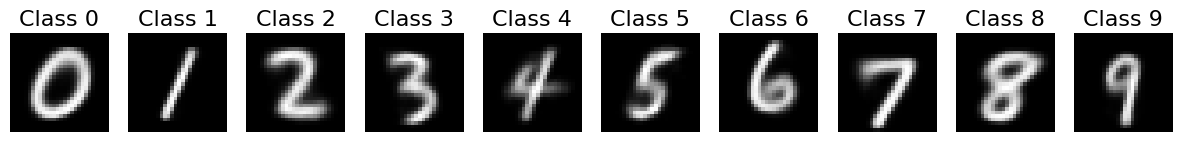


##################################################
CVAE-MLP Epoch [37/64], Loss: 132.7949663248698
Sample Images:


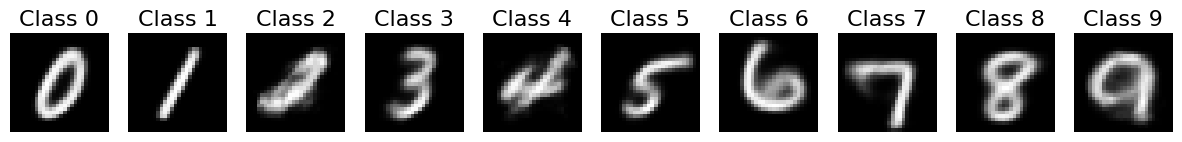


##################################################
CVAE-MLP Epoch [38/64], Loss: 132.7318166829427
Sample Images:


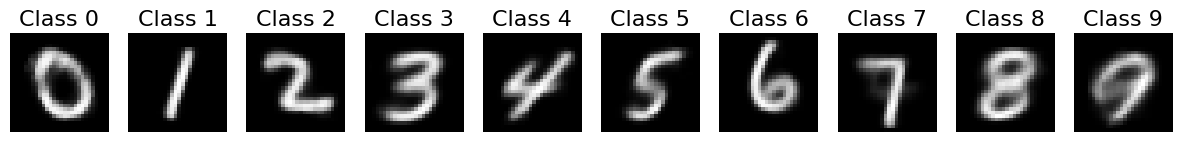


##################################################
CVAE-MLP Epoch [39/64], Loss: 132.7590735921224
Sample Images:


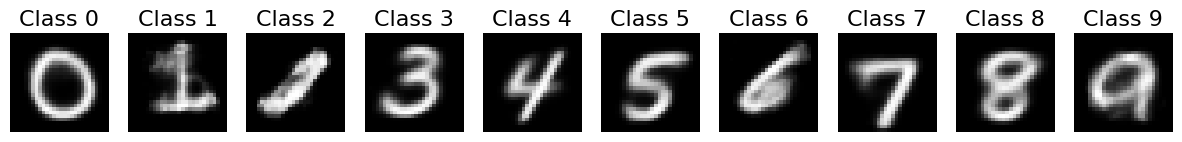


##################################################
CVAE-MLP Epoch [40/64], Loss: 132.72942919921874
Sample Images:


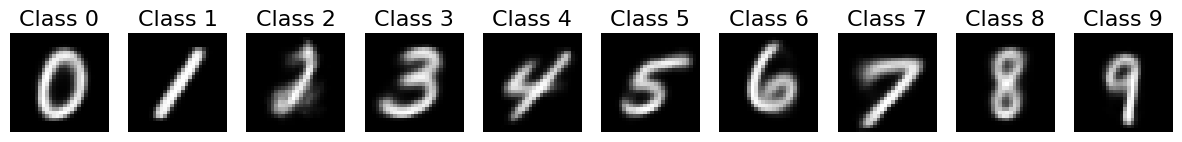


##################################################
CVAE-MLP Epoch [41/64], Loss: 132.36549934895834
Sample Images:


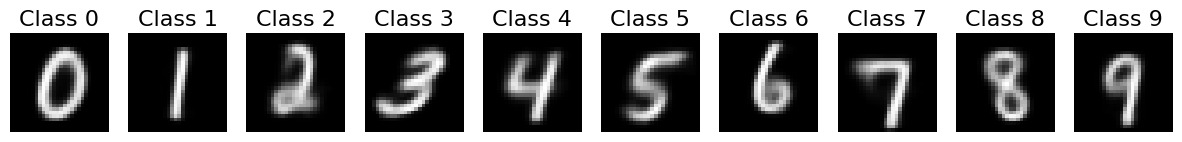


##################################################
CVAE-MLP Epoch [42/64], Loss: 132.40581990559895
Sample Images:


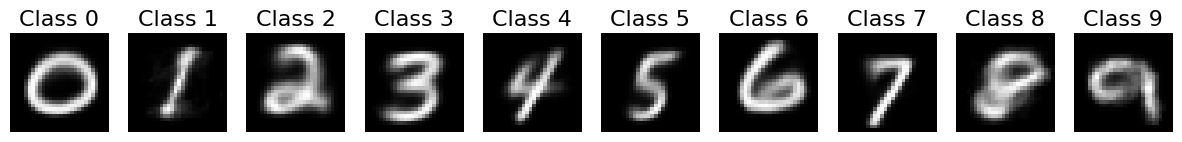


##################################################
CVAE-MLP Epoch [43/64], Loss: 132.45575288085936
Sample Images:


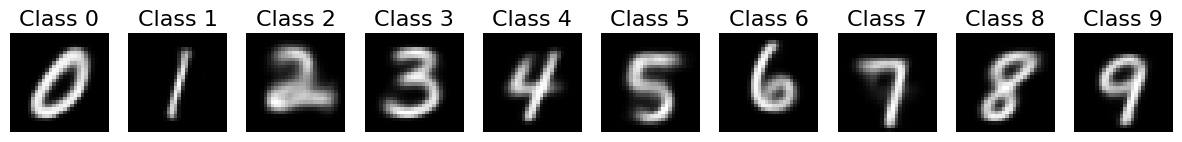


##################################################
CVAE-MLP Epoch [44/64], Loss: 132.43525595296225
Sample Images:


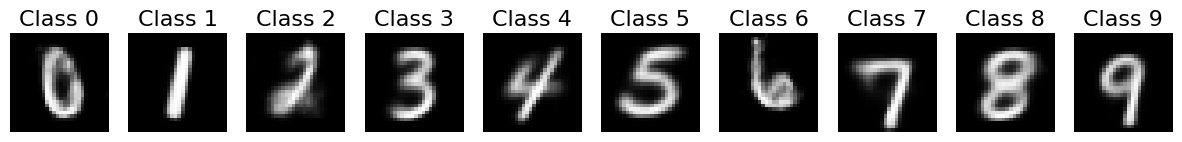


##################################################
CVAE-MLP Epoch [45/64], Loss: 132.37327086995444
Sample Images:


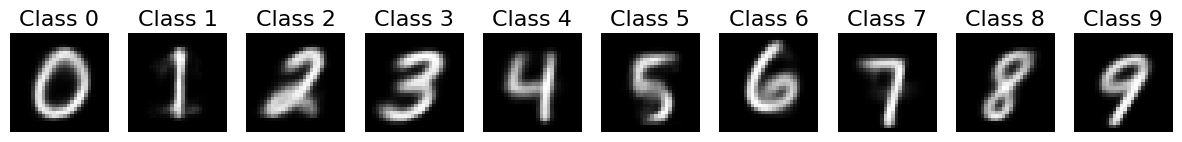


##################################################
CVAE-MLP Epoch [46/64], Loss: 132.3823326171875
Sample Images:


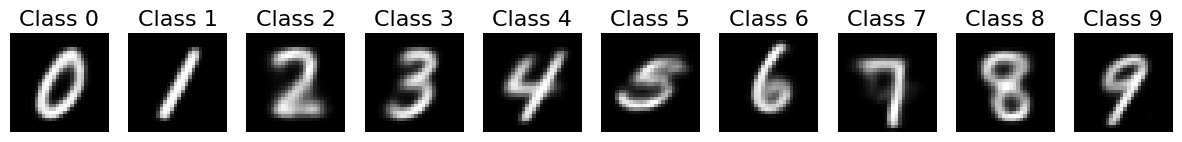


##################################################
CVAE-MLP Epoch [47/64], Loss: 132.48265928548176
Sample Images:


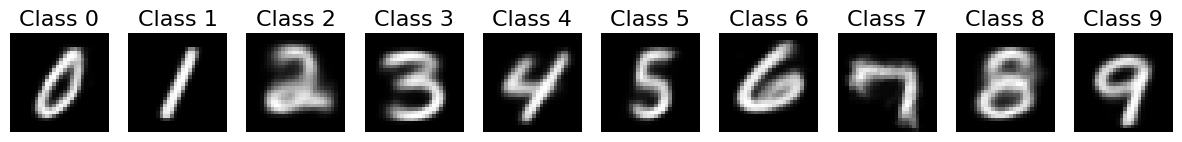


##################################################
CVAE-MLP Epoch [48/64], Loss: 132.4693362833659
Sample Images:


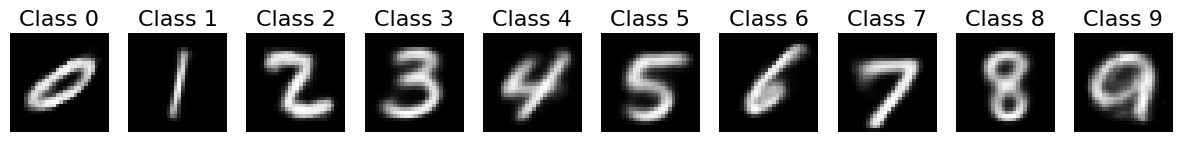


##################################################
CVAE-MLP Epoch [49/64], Loss: 132.12070735677082
Sample Images:


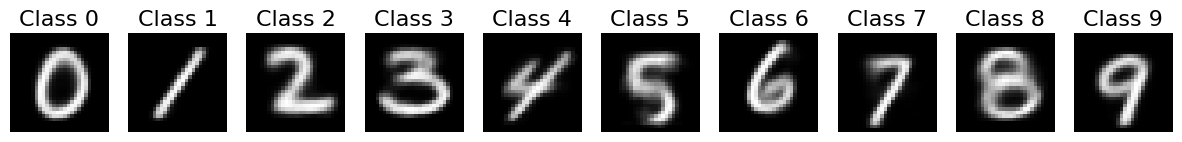


##################################################
CVAE-MLP Epoch [50/64], Loss: 132.04590708821615
Sample Images:


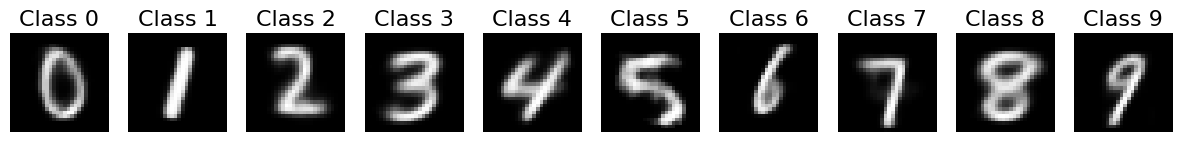


##################################################
CVAE-MLP Epoch [51/64], Loss: 132.13193546142577
Sample Images:


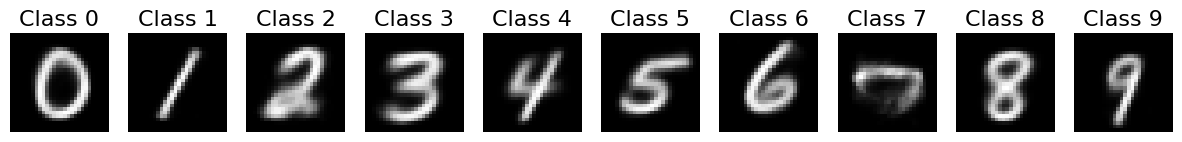


##################################################
CVAE-MLP Epoch [52/64], Loss: 132.10941647135417
Sample Images:


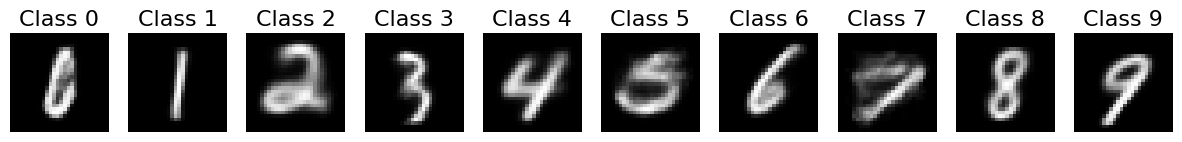


##################################################
CVAE-MLP Epoch [53/64], Loss: 132.0600069091797
Sample Images:


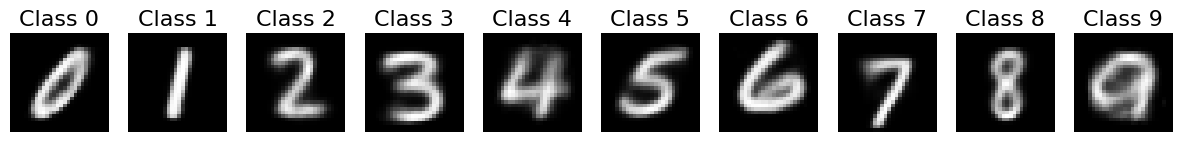


##################################################
CVAE-MLP Epoch [54/64], Loss: 132.1022214436849
Sample Images:


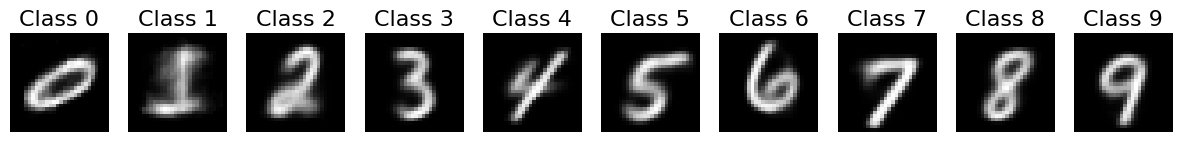


##################################################
CVAE-MLP Epoch [55/64], Loss: 131.98414815266926
Sample Images:


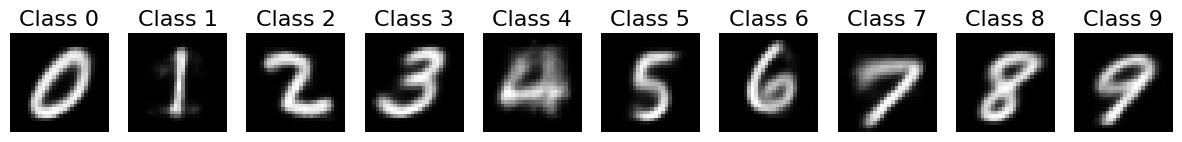


##################################################
CVAE-MLP Epoch [56/64], Loss: 132.06177001139324
Sample Images:


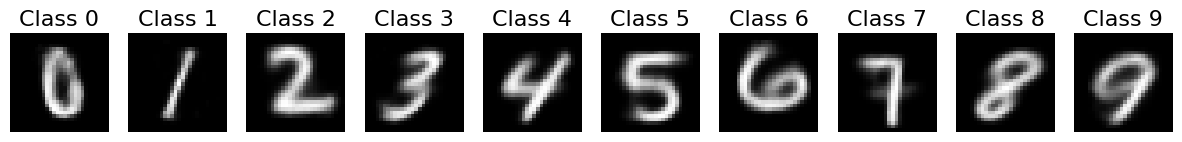


##################################################
CVAE-MLP Epoch [57/64], Loss: 131.87762130533855
Sample Images:


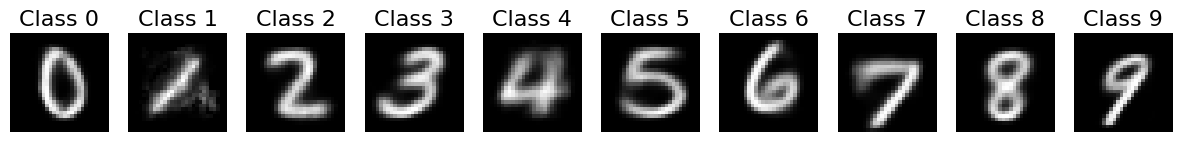


##################################################
CVAE-MLP Epoch [58/64], Loss: 132.09946765136718
Sample Images:


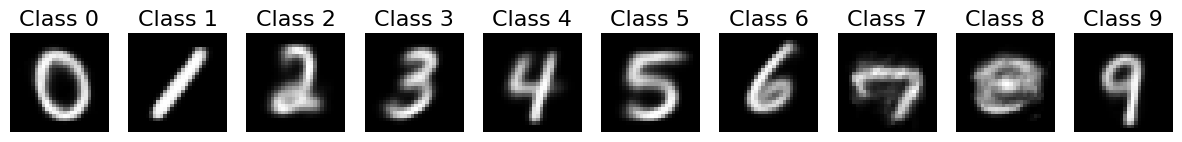


##################################################
CVAE-MLP Epoch [59/64], Loss: 131.89190716145833
Sample Images:


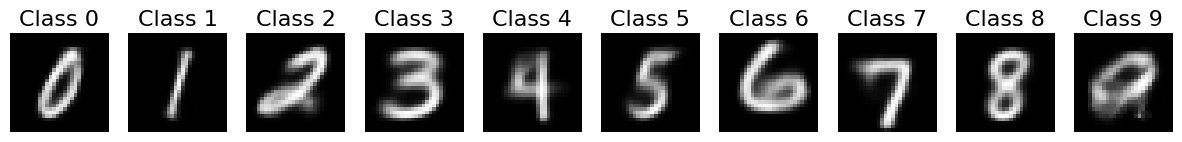


##################################################
CVAE-MLP Epoch [60/64], Loss: 131.7573738606771
Sample Images:


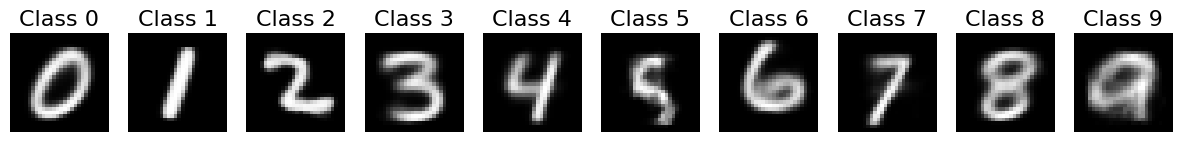


##################################################
CVAE-MLP Epoch [61/64], Loss: 131.80975598958332
Sample Images:


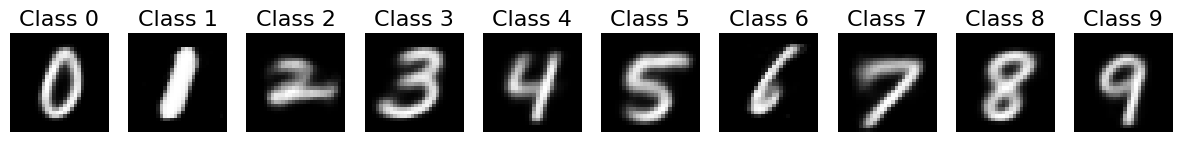


##################################################
CVAE-MLP Epoch [62/64], Loss: 131.76995380045574
Sample Images:


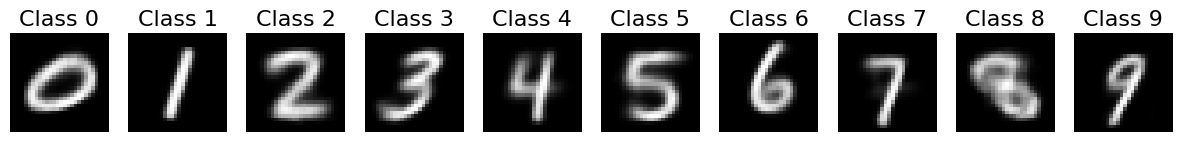


##################################################
CVAE-MLP Epoch [63/64], Loss: 131.70226411132813
Sample Images:


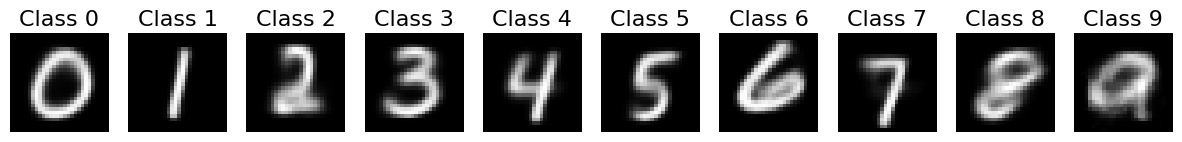


##################################################
CVAE-MLP Epoch [64/64], Loss: 131.64656877441405
Sample Images:


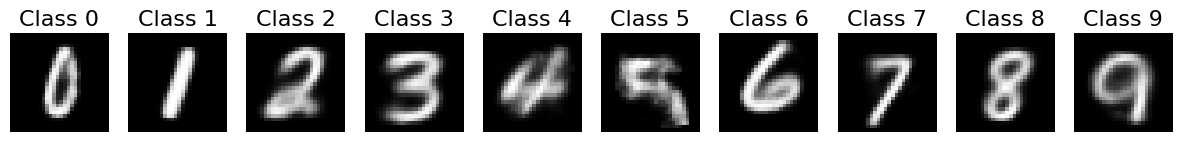

Best model saved as 'best_cvae_mlp_model.pth'


In [19]:
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim=500, latent_dim=2, num_classes=10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).




`Explanation`: Both the Variational Autoencoder (VAE) and the Conditional Variational Autoencoder (CVAE) have distributions that are normal (or Gaussian). This is due to the Kullback-Leibler (KL) divergence term in their loss functions, which encourages the latent space to follow a normal distribution.

In the VAE, the different classes in the data are separated in the latent space. This separation is due to the reconstruction loss term in the VAE’s loss function. The reconstruction loss ensures that the data can be accurately reconstructed from the latent space, which leads to a separation of different classes.

In the CVAE, this separation of classes is not as pronounced. This is because the CVAE includes a third term in its loss function, which is related to the condition of the autoencoder. This term ensures that the model takes into account the additional input information (or “conditions”) when encoding and decoding the data, which can result in a more mixed distribution in the latent space.

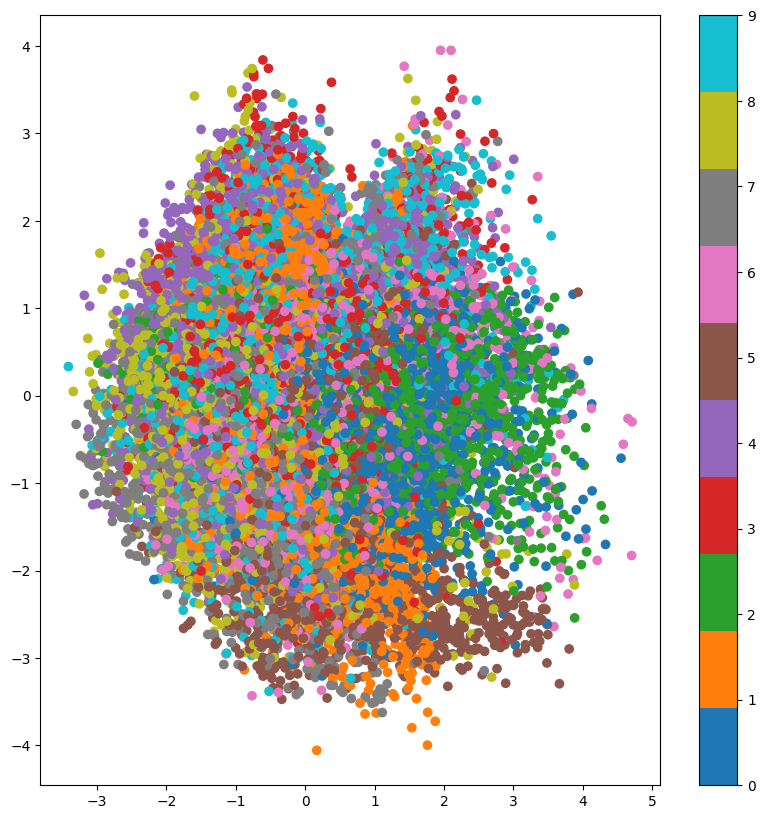

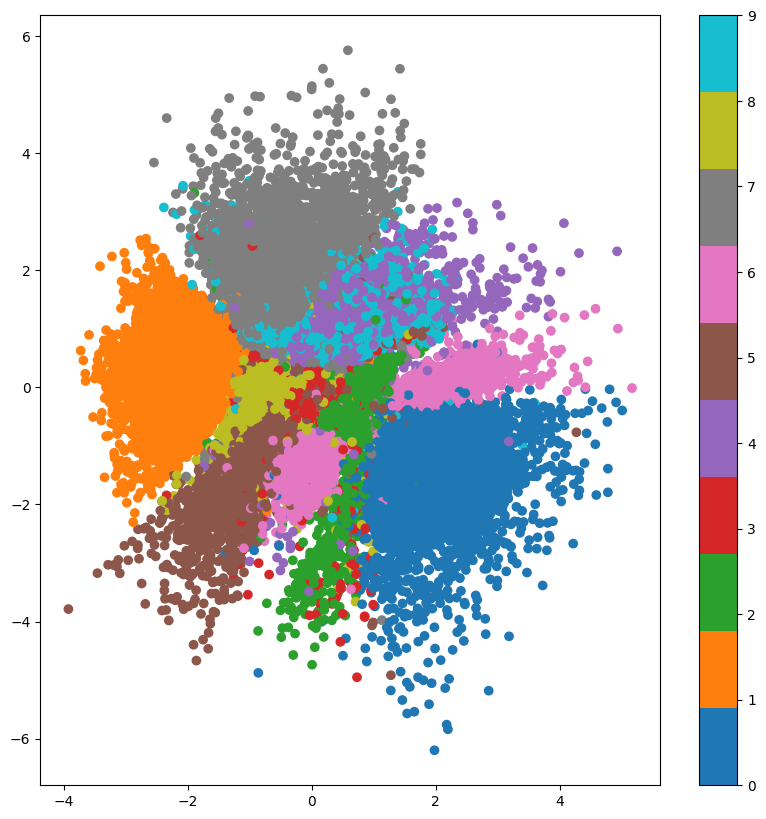

In [20]:
import matplotlib.pyplot as plt

def visualize_latent_space(model, data_loader):
    model.eval()
    with torch.no_grad():
        all_latents = []
        all_labels = []
        for data, labels in data_loader:
            data = data.view(data.size(0), -1).to(device)
            if isinstance(model, CVAE_MLP):
                labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)
                _, mu, _, _ = model(data, labels_one_hot)
            else:
                _, mu, _ = model(data)
            all_latents.append(mu.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        all_latents = np.concatenate(all_latents, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
        plt.figure(figsize=(10, 10))
        plt.scatter(all_latents[:, 0], all_latents[:, 1], c=all_labels, cmap='tab10')
        plt.colorbar()
        plt.show()

# Visualize the latent space distribution for the VAE and CVAE models
visualize_latent_space(cvae_mlp, train_loader)
visualize_latent_space(vae_mlp, train_loader)
